# NLP

## Preprocessing & Feature Engineering

    imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

    read

In [2]:
dep_clean = pd.read_csv("../data/r_depression_data/cleaned_depression_data.csv")
anx_clean = pd.read_csv("../data/r_anxiety_data/cleaned_anxiety_data.csv")

    feature engineering

In [3]:
# concat title of post with text of post
dep_clean["text"] = dep_clean["title"] + " " +  dep_clean["selftext"]
anx_clean["text"] = anx_clean["title"] + " " + anx_clean["selftext"]

In [4]:
# string length of each post ~ character count
dep_clean["char_count"] = dep_clean["selftext"].str.len()
anx_clean["char_count"] = anx_clean["selftext"].str.len()

# white spaced seperated strings ~ word count
dep_clean["word_count"] = dep_clean["selftext"].str.split().str.len()
anx_clean["word_count"] = anx_clean["selftext"].str.split().str.len()

    Visualizations: word count and character count by subreddit

In [5]:
#Downsampling for visualizations
dep_tmp = pd.DataFrame(dep_clean[["text", "subreddit", "word_count", "char_count"]].sample(50000, replace=False, random_state=137))
anx_tmp = pd.DataFrame(anx_clean[["text", "subreddit", "word_count", "char_count"]].sample(50000, replace=False, random_state=137))
clean_data = pd.concat([dep_tmp, anx_tmp])
clean_data.reset_index(inplace=True)

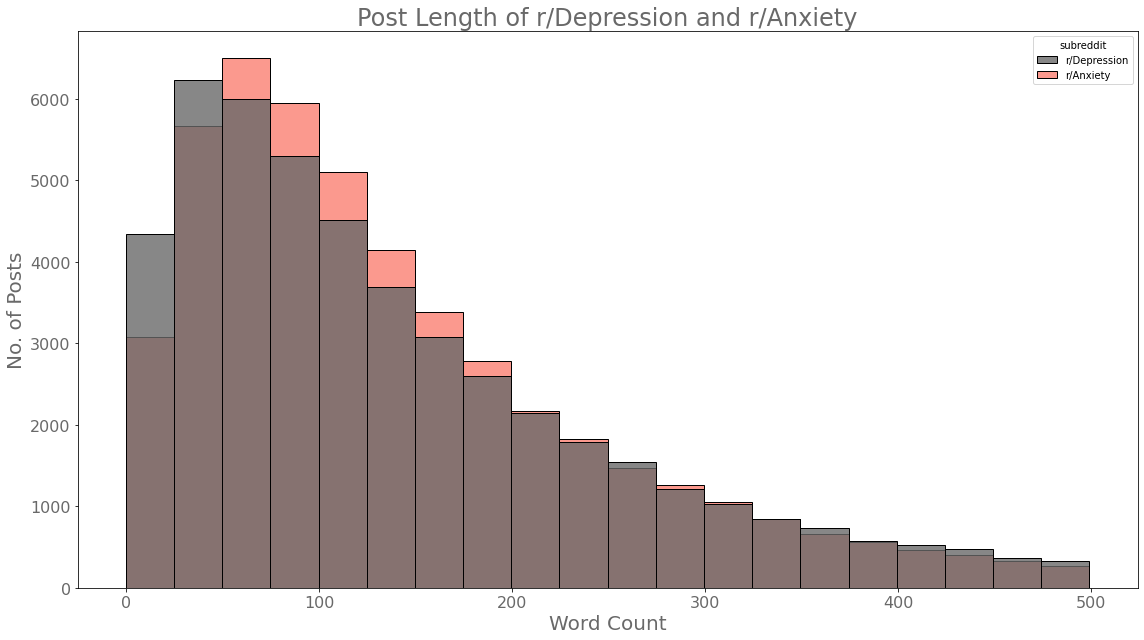

In [6]:
#Word Count plot
hue_temp = clean_data["subreddit"].map({"depression" : "r/Depression", "Anxiety" : "r/Anxiety"})
plt.figure(figsize=(16,9))
sns.histplot(data = clean_data, x = clean_data[clean_data["word_count"] < 500]["word_count"],\
             bins=20, hue=hue_temp, palette=["dimgrey", "salmon"], alpha=.8)
plt.title("Post Length of r/Depression and r/Anxiety", fontsize=24, color="dimgrey")
plt.ylabel("No. of Posts", fontsize=20, color="dimgrey")
plt.xlabel("Word Count", color="dimgrey", fontsize=20)
plt.yticks(fontsize=16, color="dimgrey")
plt.xticks(fontsize=16, color="dimgrey");
plt.tight_layout()
plt.savefig("../images/dep_anx_word_cnt.png", transparent=True);

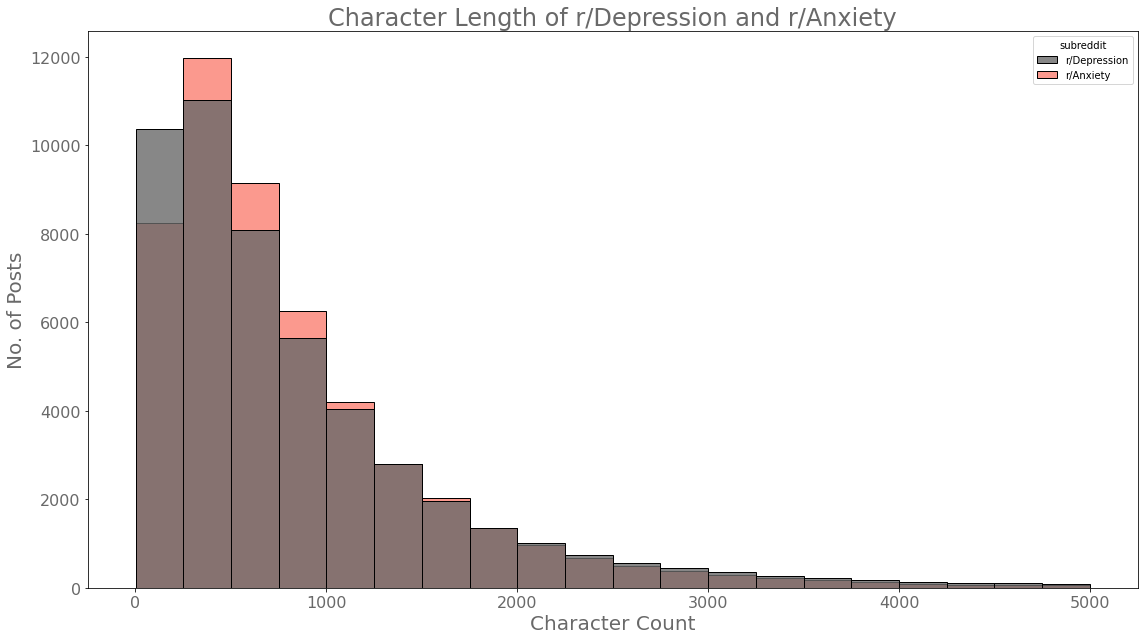

In [7]:
#Character count plot
hue_temp = clean_data["subreddit"].map({"depression" : "r/Depression", "Anxiety" : "r/Anxiety"})
plt.figure(figsize=(16,9))
sns.histplot(data = clean_data, x = clean_data[clean_data["char_count"] < 5000]["char_count"],\
             bins=20, hue=hue_temp, palette=["dimgrey", "salmon"], alpha=.8)
plt.title("Character Length of r/Depression and r/Anxiety", fontsize=24, color="dimgrey")
plt.ylabel("No. of Posts", fontsize=20, color="dimgrey")
plt.xlabel("Character Count", color="dimgrey", fontsize=20)
plt.yticks(fontsize=16, color="dimgrey")
plt.xticks(fontsize=16, color="dimgrey");
plt.tight_layout()
plt.savefig("../images/dep_anx_char_cnt.png", transparent=True);

In [8]:
#
dep_tmp.drop(dep_tmp[dep_tmp["word_count"] < 15]["text"].index, inplace=True)
anx_tmp.drop(anx_tmp[anx_tmp["word_count"] < 15]["text"].index, inplace=True)

dep_tmp.drop(dep_tmp[dep_tmp["word_count"] > 824]["text"].index, inplace=True)
anx_tmp.drop(anx_tmp[anx_tmp["word_count"] > 824]["text"].index, inplace=True)

clean_data_slice = pd.concat([dep_tmp, anx_tmp])
clean_data_slice.reset_index(inplace=True, drop=True)

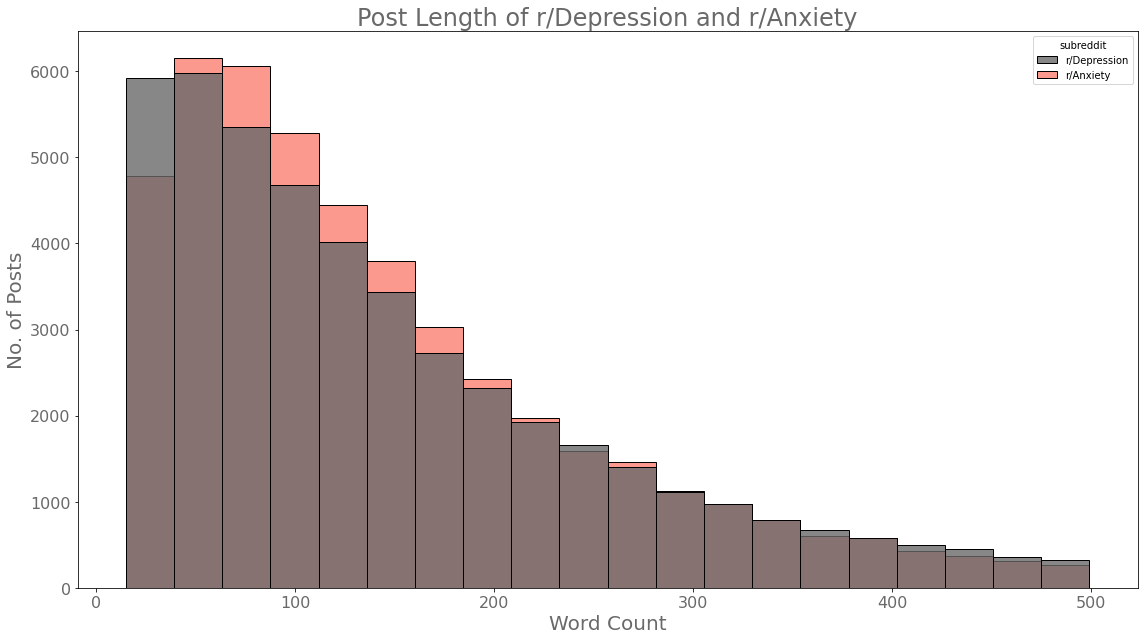

In [9]:
hue_temp = clean_data_slice["subreddit"].map({"depression" : "r/Depression", "Anxiety" : "r/Anxiety"})
plt.figure(figsize=(16,9))
sns.histplot(data = clean_data, x = clean_data_slice[clean_data_slice["word_count"] < 500]["word_count"],\
             bins=20, hue=hue_temp, palette=["dimgrey", "salmon"], alpha=.8)
plt.title("Post Length of r/Depression and r/Anxiety", fontsize=24, color="dimgrey")
plt.ylabel("No. of Posts", fontsize=20, color="dimgrey")
plt.xlabel("Word Count", color="dimgrey", fontsize=20)
plt.yticks(fontsize=16, color="dimgrey")
plt.xticks(fontsize=16, color="dimgrey");
plt.tight_layout()
plt.savefig("../images/dep_anx_word_cnt_sliced.png", transparent=True);

Removing posts less than 15 words removes the first bar from the histogram. Perhaps more could be done to sculpt the data. Reasoning behind this transform is explained in preprocessing.

In [10]:
#Even with >180000 posts our over_18 tag is too sparse to be noticed
# x_temp = dep_clean[dep_clean["word_count"] < 2000]["word_count"]
# hue_temp = dep_clean["over_18"].map({True : 1, False : 0})
# sns.histplot(data=dep_clean, x = x_temp, hue = hue_temp, bins=20)

    preprocessing

Removing posts less 15 words and more than 825 words, sculpting our data set:
1. r/depression has shorter posts, these shoter posts often have keywords specific to r/depression. We do not want our model to learn this.
2. These posts often fail to articulate a meaningful utterance.

In [11]:
#dropping observations with wordcount less than 15
dep_clean.drop(dep_clean[dep_clean["word_count"] < 15]["text"].index, inplace=True)
anx_clean.drop(anx_clean[anx_clean["word_count"] < 15]["text"].index, inplace=True)

#dropping observations with wordcount greater than 825
dep_clean.drop(dep_clean[dep_clean["word_count"] > 824]["text"].index, inplace=True)
anx_clean.drop(anx_clean[anx_clean["word_count"] > 824]["text"].index, inplace=True)

In [11]:
#Tokenize with regex pattern selecting "words" only join list of strings with white space
#lowercase to reduce dimensionality(e.g. My = my)
#more efforts could be made to filter hyperlinks
dep_clean["text"] = dep_clean["text"].map(RegexpTokenizer(r"\w+").tokenize)
dep_clean["text"] = dep_clean["text"].map(lambda x: " ".join(x))
dep_clean["text"] = dep_clean["text"].map(str.lower)

anx_clean["text"] = anx_clean["text"].map(RegexpTokenizer(r"\w+").tokenize)
anx_clean["text"] = anx_clean["text"].map(lambda x: " ".join(x))
anx_clean["text"] = anx_clean["text"].map(str.lower)

In [12]:
# pstems = PorterStemmer()
# dep_clean["text"] = dep_clean["text"].map(lambda x: [pstems.stem(y) for y in x])
# anx_clean["text"] = anx_clean["text"].map(lambda x: [pstems.stem(y) for y in x])

In [14]:
# stems = SnowballStemmer("english")
# dep_clean["text"] = dep_clean["text"].map(lambda x: [stems.stem(y) for y in x])
# anx_clean["text"] = anx_clean["text"].map(lambda x: [stems.stem(y) for y in x])

In [13]:
# lemmings = WordNetLemmatizer()
# dep_clean["text"] = dep_clean["text"].map(lambda x: [lemmings.lemmatize(y) for y in x])
# anx_clean["text"] = anx_clean["text"].map(lambda x: [lemmings.lemmatize(y) for y in x])

Stemming and lemmatizing are explored.

As described in the executive summary we will form inferences about the linguistics of depressed posts vs. anxiety posts; latent features in our bag of words model. Upon examing the results of stemming and lemmatizing, potentially important lexical items might be lost with these methods.

In [15]:
#Stop words list is generated as the union of nltk's stop words and CountVectorizer's stopwords.
#This is expanded into a custom stopwords list after insights from the modeling step.
sw = set(stopwords.words("english"))
cv = set(CountVectorizer(stop_words="english").get_stop_words())
set(cv | sw);

In [33]:
s_w = ['up', 'me', 'which', 'her', 'although', 'afterwards', 'can', 'below', 'couldnt', 'co', 'sometimes',
'must', 'whither', "that'll", 'weren', 'will', "wasn't", "wouldn't", 'such', 'somewhere', 'amoungst',
'whereafter', 'into', 'is', 'themselves', 'in', 'at', 'hereupon', 'only', 'top', 'becomes', 'they',
"shouldn't", 'it', 'whoever', 'meanwhile', 'keep', 'haven', 'among', 'with', 'next', 'three', 'as',
'above', 'has', 'none', 'less', 're', 'been', 'former', 'third', 'wasn', 'may', 'being', 'anyway',
'had', 'somehow', 'whenever', 'won', 'where', 'get', 'across', "it's", 'least', "you'd", 'many',
"haven't", 'm', 'during', 'might', 'we', 'didn', 'myself', 'via', 'again', 'sometime', 'put', 'that',
'beforehand', 'much', "aren't", 'anyhow', 'everything', 'last', 'seems', 'and', 'inc', 'other',
'still', 'whence', 'more', 'rather', 'side', 'due', 'per', 'thin', 'shan', 'thereupon', 'isn', 'us',
'anyone', 'mine', 'seem', 'all', 'toward', 'own', 'when', 'thick', 'became', 'eg', 'down', 'him',
'done', 'beside', 'fire', 'same', 'were', 'about', 'ourselves', 'shouldn', 'find', "hasn't", 'un',
'sixty', 'hundred', 'ie', 'nor', 'hers', 'now', 'wherein', 'hereafter', 'whom', 'yourselves',
"mightn't", 'two', 'whose', 'around', 'enough', 'very', "won't", 'always', "don't", 'an', 'cant',
'amongst', 'while', 'found', 'never', 'what', 'etc', 'having', 'most', 'ten', 'bill', 'along', 'be',
'herein', 'without', "shan't", 'five', "you'll", 'become', 'one', "you've", 'even', 'call', 'show',
'another', 'thereafter', 'mill', 'off', 'thence', 'something', 'couldn', 'but', 'cannot', "weren't",
'hadn', 'mostly', 't', 'however', 'con', 'not', 'nevertheless', 'nowhere', 'why', 'anywhere', 'thus',
'anything', 'further', 'doesn', 'after', 'nothing', 'sincere', "didn't", 'o', 'have', 'nobody', 'do',
'of', "mustn't", 'elsewhere', 'don', 'could', 'them', 'those', 'whatever', 'empty', 'thru', 'noone',
'your', 'for', 'herself', 'yourself', 'hence', 'their', 'thereby', 'latterly', 'six', 'was', 'our',
'formerly', 'any', 'needn', 'these', 'moreover', 'take', "she's", 'few', 'from', 'did', 'often',
'forty', "couldn't", 'aren', 'bottom', 'perhaps', "hadn't", 'twelve', 'others', 'name', 'then',
'made', 'my', 'than', 'already', "should've", 'since', 'theirs', 'wherever', 'i', 'therein', 'between',
'some', 'full', 'neither', 'go', 'ours', 'first', 'amount', 'doing', "doesn't", 'whereby',
'several', 'yet', 'there', 'twenty', 'interest', 'front', 'namely', 'therefore', 'no', 'hereby',
'under', 'throughout', 'the', 'just', 'against', 'hasnt', 'eleven', 'once', 'by', 'describe',
'does', 'every', 'this', 'wouldn', 'eight', 'yours', "isn't", 'de', 'within', 'so', 'behind',
'either', 'cry', 'on', 'else', 'ever', 'until', 'latter', 'whether', 'nine', 'to', 'seeming',
'each', 'how', 'himself', 'before', 'beyond', 'alone', 'its', 'hasn', 've', 'towards', 'you',
'detail', 'except', 'though', 'itself', 'he', 'system', 'who', 'ma', 'are', 'or', 'here', "you're",
'someone', 'give', 'serious', 'mightn', 'everywhere', 'upon', 'over', 'also', 'his', 'too', 'together',
'both', 'fifteen', 'seemed', 'fill', 's', 'ain', 'whereupon', 'becoming', 'would', 'd', 'otherwise',
'should', 'y', 'she', 'onto', 'see', 'almost', 'back', 'well', 'fifty', 'whole', 'part', "needn't",
'everyone', 'indeed', 'four', 'out', 'am', 'through', 'ltd', 'move', 'mustn', 'besides', 'if', 'll',
'please', 'whereas', 'because', 'a', "ve", "youtube", "youtube com", '00', '000', '10 15', '10 days',
 '10 hours', '10 minutes', '10 months', '10 times', '95', '99', 'youtube videos',  'www reddit',
"www", "http", "https", "reddit", "subreddit", "r", "youtube com", "youtu", "youtube"]

List is expanded when erroneous terms are detected as important features.

In [34]:
# remove stop words from each dataframe
dep_clean["text"] = dep_clean["text"].map(lambda x: " ".join(w for w in x.split() if w not in s_w))
anx_clean["text"] = anx_clean["text"].map(lambda x: " ".join(w for w in x.split() if w not in s_w))

In [35]:
# removing leading and trailing white space from each dataframe
dep_clean["text"] = dep_clean["text"].map(str.strip)
anx_clean["text"] = anx_clean["text"].map(str.strip)

    Sentiment Analysis

In [19]:
# Apply sentiment analyzer to each document returns a dict of scores {pos, neu, neg, compound}
# unpack dictionary of sentitment scores into a temp df
sia           = SentimentIntensityAnalyzer()

sent_dict_dep = dep_clean["text"].map(lambda x: sia.polarity_scores(x))
sent_dep_df   = sent_dict_dep.map(lambda x: [v for k, v in x.items()]).apply(pd.Series)

sent_dict_anx = anx_clean["text"].map(lambda x: sia.polarity_scores(x))
sent_anx_df   = sent_dict_anx.map(lambda x: [v for k, v in x.items()]).apply(pd.Series)

In [20]:
# merge sentiment df with each dataframe
dep_clean[["negative", "neutral", "positive", "compound"]] = sent_dep_df
anx_clean[["negative", "neutral", "positive", "compound"]] = sent_anx_df

In [36]:
#visual inspection of excerpts from each dataframe
dep_clean["text"].sample(50)

54545     ssris work tried lexapro zoloft officially dia...
13733     think healthy relationship real relationship 2...
93570     tell expect mental health social worker hi liv...
96618     angry filled hate rage existence people gone w...
9729      sinking diary entry 4 passed away anchor life ...
168221    losing hope thinking younger anxious leave sch...
168815    feel terrible depression spiraling going zoom ...
54373     bipolar disorder manic episode people insist t...
87440     need rant dad family artistic loved art day da...
155588    gets worse worse like things used like feel li...
87585     video today getting ready start working days t...
144809    feel like forever friends depressed life takin...
21914     family members making feel really bad attendin...
182617    feel worthless unmotivated honesty know feel l...
28413     insert depression avoiding people bad said sta...
64867     therapist given obviously words really tone ac...
123071    feel bad hanging people posts 

In [37]:
# visual inspection of excerpts from each dataframe
anx_clean["text"].sample(50)

82573     help really need support 27 male little month ...
102441    felt like hello sorry long post toddler gettin...
146448    hyper aware breathing hi months anxiety gone m...
138417    anxious work rn struggling jaw clenched should...
31992     anxiety medication years years struggling anxi...
223895    lump cancer fear calm night itching groin biki...
148347    ghosted dentist work crazy long disjointed hou...
84975     good day small earthquake night 2 apartment sh...
177334    asking friend severe anxiety constantly thinki...
26191     rid anxiety thinking title anxiety 30 days ter...
211842    genital tingling pulsing really love know caus...
199115    stopping ssris tips success ssris 3 yeas gener...
182439    issues life self doubt married porn social anx...
70661     extreme anxiety getting bad tattoo hello weeks...
201265    coping improves anxiety gets worse relate prov...
185659    catastrophic thinking destroying productivity ...
110595    feel like youre losing touch r

In [38]:
# checking final shape after preprocessing
dep_clean.shape, anx_clean.shape

((188011, 12), (226184, 12))

In [39]:
# reset index before export
anx_clean.reset_index(inplace=True, drop=True)
dep_clean.reset_index(inplace=True, drop=True)

    export

In [40]:
dep_clean.to_csv("../data/r_depression_data/engineered_depression_data.csv", index=False)
anx_clean.to_csv("../data/r_anxiety_data/engineered_anxiety_data.csv", index=False)